# Machine Learning

In this file, instructions how to approach the challenge can be found.

We are going to work on different types of Machine Learning problems:

- **Regression Problem**: The goal is to predict delay of flights.
- **(Stretch) Multiclass Classification**: If the plane was delayed, we will predict what type of delay it is (will be).
- **(Stretch) Binary Classification**: The goal is to predict if the flight will be cancelled.

In [2]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, OneHotEncoder
scaler = StandardScaler()
le = preprocessing.LabelEncoder()
enc = OneHotEncoder()
import xgboost as xgb
import seaborn as sns

In [3]:
olsInitial = pd.read_csv('OLSinitial.csv')

In [4]:
Flights = pd.read_csv('Flights-300K.csv')

In [5]:
trainData2018 = pd.read_csv('trainData2018.csv')
trainData2019 = pd.read_csv('trainData2019.csv')

## Main Task: Regression Problem

The target variable is **ARR_DELAY**. We need to be careful which columns to use and which don't. For example, DEP_DELAY is going to be the perfect predictor, but we can't use it because in real-life scenario, we want to predict the delay before the flight takes of --> We can use average delay from earlier days but not the one from the actual flight we predict.  

For example, variables **CARRIER_DELAY, WEATHER_DELAY, NAS_DELAY, SECURITY_DELAY, LATE_AIRCRAFT_DELAY** shouldn't be used directly as predictors as well. However, we can create various transformations from earlier values.

We will be evaluating your models by predicting the ARR_DELAY for all flights **1 week in advance**.

In [6]:
mainTrainData = pd.concat([trainData2018, trainData2019], ignore_index=True)

<AxesSubplot:xlabel='arr_delay'>

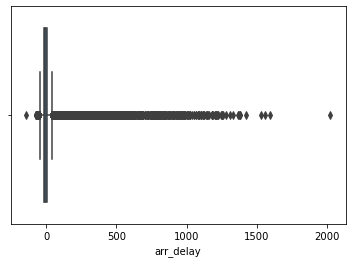

In [7]:
sns.boxplot(x=mainTrainData['arr_delay'])

In [6]:
#Using the new and improved data! Thanks Karan :D

#OLS Model - updated data, dummies of mkt_carrier
mainTrainData = pd.concat([trainData2018, trainData2019], ignore_index=True)
mainTrainData = mainTrainData.dropna()
mktCarrierDummies = pd.get_dummies(mainTrainData['mkt_unique_carrier'])
mainTrainData = pd.concat([mainTrainData, mktCarrierDummies], axis=1)
y = mainTrainData['arr_delay'].values.reshape(-1,1)
X = mainTrainData.drop(columns = ['fl_date', 'mkt_unique_carrier','op_unique_carrier','origin','dest','arr_delay'])
X['distanceSQ'] = X['distance']**2
X['const'] = 1
XScaled = scaler.fit_transform(X)
yScaled = scaler.fit_transform(y)
X_train, X_test, y_train, y_test = train_test_split(XScaled, yScaled, train_size = 0.75, random_state=5)
linreg = LinearRegression()
linreg.fit(X_train, y_train)
y_pred = linreg.predict(X_test)
print('MSE: ', mean_squared_error(y_test, y_pred))
print('R^2 Score: ', linreg.score(X_test, y_test))
print('R^2 Adj-Score: ', 1-(1-r2_score(y_test, y_pred))*((len(X_test)-1)/(len(X_test)-len(X_test[0])-1)))



MSE:  3.8656534545910847e+21
R^2 Score:  -3.735248816088104e+21
R^2 Adj-Score:  -3.7551095567860027e+21


In [73]:
# enc_mkt_unique_carrier = enc.fit_transform(mainTrainData['mkt_unique_carrier'].values.reshape(-1,1)).toarray()
# enc_mkt_unique_carrier

In [81]:
X.head(1)

,crs_dep_time,distance,AA,AS,B6,DL,F9,G4,HA,NK,UA,VX,WN,distanceSQ,const
0,1435,529,1,0,0,0,0,0,0,0,0,0,0,279841,1


In [82]:
linreg.coef_

array([[ 9.06869827e-02,  9.75394750e-04, -1.24691503e+10,
        -6.43013561e+09, -5.44819561e+09, -1.17818697e+10,
        -3.52018445e+09, -3.17396568e+09, -3.03768899e+09,
        -4.29596436e+09, -1.12515281e+10, -1.00329896e+09,
        -1.07256949e+10, -2.18562156e-02,  0.00000000e+00]])

MSE:  1.022401805590472
R^2 Score:  0.01208807805506662
R^2 Adj-Score:  0.011899993919522567


In [52]:
#OLS Model - Distance Squared added as a feature
filteredFlights = Flights[['mkt_carrier_fl_num', 'op_carrier_fl_num', 'origin_airport_id', 'dest_airport_id', 'crs_dep_time', 'crs_arr_time', 'distance', 'arr_delay']]
filteredFlights = filteredFlights.dropna()
y = filteredFlights.iloc[:, -1:]
X = filteredFlights.iloc[:,1:-1]
X['distanceSQ'] = X['distance']**2
X['const'] = 1
XScaled = scaler.fit_transform(X)
yScaled = scaler.fit_transform(y)
X_train, X_test, y_train, y_test = train_test_split(XScaled, yScaled, train_size = 0.75, random_state=5)
linreg = LinearRegression()
linreg.fit(X_train, y_train)
y_pred = linreg.predict(X_test)
print('MSE: ', mean_squared_error(y_test, y_pred))
print('R^2 Score: ', linreg.score(X_test, y_test))
print('R^2 Adj-Score: ', 1-(1-r2_score(y_test, y_pred))*((len(X_test)-1)/(len(X_test)-len(X_test[0])-1)))

MSE:  0.9743619409286973
R^2 Score:  0.009230237571475342
R^2 Adj-Score:  0.009122877787932193


In [53]:
y.shape

(295348, 1)

In [132]:
#XGBoost Model - Distance Squared added as a feature

filteredFlights = Flights[['mkt_carrier_fl_num', 'op_carrier_fl_num', 'origin_airport_id', 'dest_airport_id', 'crs_dep_time', 'crs_arr_time', 'distance', 'arr_delay']]
filteredFlights = filteredFlights.dropna()
y = filteredFlights.iloc[:, -1:]
X = filteredFlights.iloc[:,1:-1]
X['distanceSQ'] = X['distance']**2
XScaled = scaler.fit_transform(X)
yScaled = scaler.fit_transform(y)

data_dmatrix = xgb.DMatrix(data=XScaled,label=yScaled)

X_train, X_test, y_train, y_test = train_test_split(XScaled, yScaled, train_size = 0.75, random_state=5)
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.01,
                max_depth = 8, alpha = 10, n_estimators = 10)

xg_reg.fit(X_train, y_train)
y_pred = xg_reg.predict(X_test)
print('MSE: ', mean_squared_error(y_test, y_pred))
print('R^2 Score: ', linreg.score(X_test, y_test))
print('R^2 Adj-Score: ', 1-(1-r2_score(y_test, y_pred))*((len(X_test)-1)/(len(X_test)-len(X_test[0])-1)))

MSE:  1.1853815603259685
R^2 Score:  0.009230237571475342
R^2 Adj-Score:  -0.20545714131937332


In [138]:
#Baseline OLS Model - No Feature Engineering

filteredFlights = Flights[['mkt_carrier_fl_num', 'op_carrier_fl_num', 'origin_airport_id', 'dest_airport_id', 'crs_dep_time', 'crs_arr_time', 'distance', 'arr_delay']]
filteredFlights = filteredFlights.dropna()
y = filteredFlights.iloc[:, -1:]
X = filteredFlights.iloc[:,1:-1]
X['const'] = 1
XScaled = scaler.fit_transform(X)
yScaled = scaler.fit_transform(y)
X_train, X_test, y_train, y_test = train_test_split(XScaled, yScaled, train_size = 0.75, random_state=5)
linreg = LinearRegression()
linreg.fit(X_train, y_train)
y_pred = linreg.predict(X_test)
print('MSE: ', mean_squared_error(y_test, y_pred))
print('R^2 Score: ', linreg.score(X_test, y_test))
print('R^2 Adj-Score: ', 1-(1-r2_score(y_test, y_pred))*((len(X_test)-1)/(len(X_test)-len(X_test[0])-1)))

MSE:  0.9747221620357202
R^2 Score:  0.008863950501306617
R^2 Adj-Score:  0.008769977234074355


In [38]:
# X['mkt_unique_carrier'] = le.fit_transform(X['mkt_unique_carrier'])

In [39]:
# X['op_unique_carrier'] = le.fit_transform(X['op_unique_carrier'])

In [40]:
# X['origin'] = le.fit_transform(X['origin'])

In [41]:
# X['dest'] = le.fit_transform(X['dest'])

### Feature Engineering

Feature engineering will play a crucial role in this problems. We have only very little attributes so we need to create some features that will have some predictive power.

- weather: we can use some weather API to look for the weather in time of the scheduled departure and scheduled arrival.
- statistics (avg, mean, median, std, min, max...): we can take a look at previous delays and compute descriptive statistics
- airports encoding: we need to think about what to do with the airports and other categorical variables
- time of the day: the delay probably depends on the airport traffic which varies during the day.
- airport traffic
- unsupervised learning as feature engineering?
- **what are the additional options?**: Think about what we could do more to improve the model.

### Feature Selection / Dimensionality Reduction

We need to apply different selection techniques to find out which one will be the best for our problems.

- Original Features vs. PCA conponents?

### Modeling

Use different ML techniques to predict each problem.

- linear / logistic / multinomial logistic regression
- Naive Bayes
- Random Forest
- SVM
- XGBoost
- The ensemble of your own choice

### Evaluation

You have data from 2018 and 2019 to develop models. Use different evaluation metrics for each problem and compare the performance of different models.

You are required to predict delays on **out of sample** data from **first 7 days (1st-7th) of January 2020** and to share the file with LighthouseLabs. Sample submission can be found in the file **_sample_submission.csv_**

======================================================================
## Stretch Tasks

### Multiclass Classification

The target variables are **CARRIER_DELAY, WEATHER_DELAY, NAS_DELAY, SECURITY_DELAY, LATE_AIRCRAFT_DELAY**. We need to do additional transformations because these variables are not binary but continuos. For each flight that was delayed, we need to have one of these variables as 1 and others 0.

It can happen that we have two types of delays with more than 0 minutes. In this case, take the bigger one as 1 and others as 0.

### Binary Classification

The target variable is **CANCELLED**. The main problem here is going to be huge class imbalance. We have only very little cancelled flights with comparison to all flights. It is important to do the right sampling before training and to choose correct evaluation metrics.